In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results, output_vqte_results
from vqteMethods import hamiltonian_generation, perform_vqte

In [ ]:

def main():
    # Initialize the simulation parameters
    N = 3
    gamma=0.05
    eps= 1
    mu_L=2
    mu_R=0.1
    T_L = 10
    T_R= 5
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1
  
    time = 1000.0
    dt = 2.0
    nt = int(time/dt)
    exact_diag_ham= build_exact_diag_hamiltonian(N,J, eps)
    print("Exact Ham", exact_diag_ham)

   
    ham_real, ham_imag = hamiltonian_generation(N, eps, gamma, F_L, F_R, J)
    print("Ham imag", ham_imag)
    print("Ham real", ham_real)

    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real,N)
    exact_diag_results, time_points = perform_exact_diag(gamma, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N,eps)

    print("VQTE initial state", vqte_init_state)
    print("Exact initial state:",exact_diag_init_state)
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    output_vqte_results(vqte_results, time, nt)
    # # Perform exact diagonalization

   
    # exact_diag_results = []
    # time_points = []
    # # Perform VQTE simulation

    # # Output results
    output_results(vqte_results, exact_diag_results, time, nt, time_points)

Exact Ham [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
Ham imag SparsePauliOp(['XXIIII', 'YYIIII', 'IXXIII', 'IYYIII', 'IIXXII', 'IIYYII', 'IIIXXI', 'IIIYYI', 'IIIIXX', 'IIIIYY', 'IIIIII', 'ZIIIII', 'IIIIIZ'],
              coeffs=[-0.025     +0.j,  0.025     +0.j, -0.025     +0.j,  0.025     +0.j,
 -0.025     +0.j,  0.025     +0.j, -0.025     +0.j,  0.025     +0.j,
 -0.025     +0.j,  0.025     +0.j,  0.05      +0.j, -0.01187552+0.j,
 -0.01362197+0.j])
Ham real SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'XYIIII', 'YXIIII', 'IXYIII', '

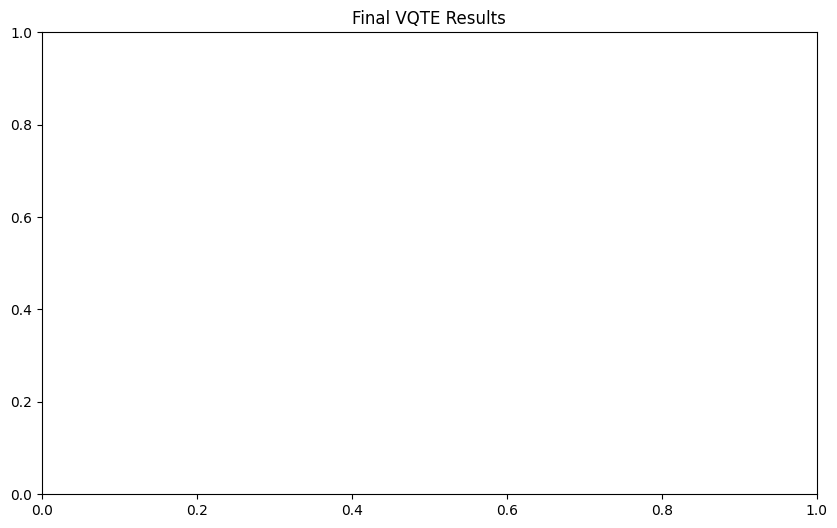

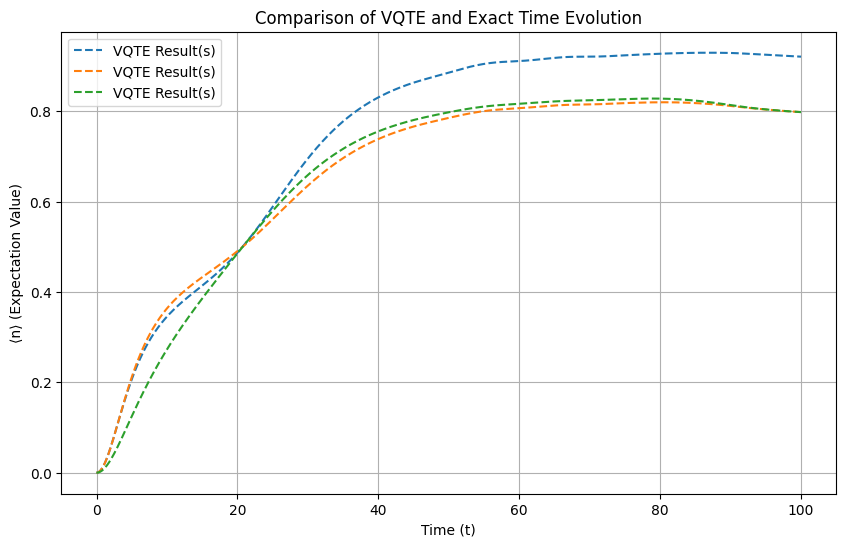

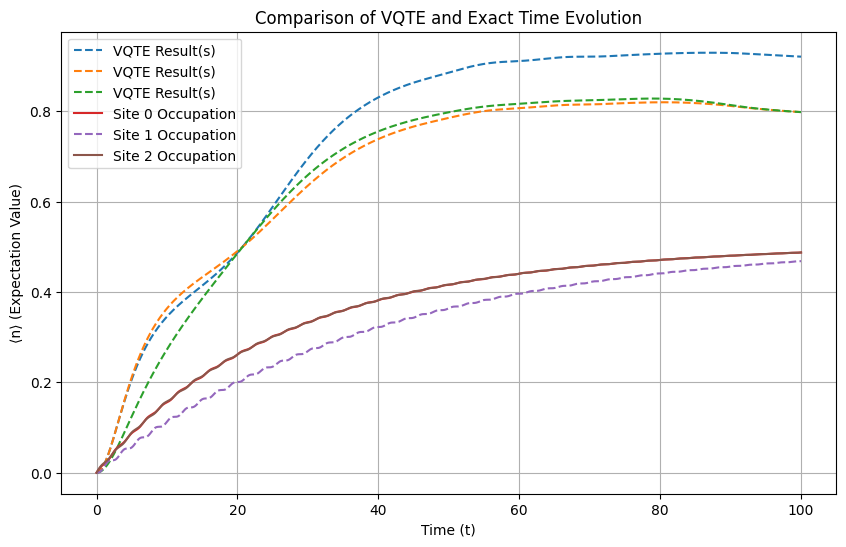

In [3]:
main()